In [1]:
import numpy as np
import cv2
import tqdm
import matplotlib.pyplot as plt
import imageio.v3 as iio
import imageio
from PIL import Image
from scipy.signal import convolve2d, unit_impulse, butter, filtfilt

In [2]:
dtype=np.float32

# Part 1: Laplacian Pyramids

In [3]:
G = cv2.getGaussianKernel(13, 3)
gaussian_kernel = np.outer(G, G)

yiq_from_rgb = (
    np.array(
            [
                [0.29900000,  0.58700000,  0.11400000],
                [0.59590059, -0.27455667, -0.32134392],
                [0.21153661, -0.52273617,  0.31119955]
            ]
        )
    ).astype(dtype)


rgb_from_yiq = np.linalg.inv(yiq_from_rgb)

def rgb2yiq(im):
    im = im.astype(dtype)
    return im @ yiq_from_rgb.T

def yiq2rgb(im):
    im = im.astype(dtype)
    return im @ rgb_from_yiq.T

def downSample(im, kernel):
    return cv2.filter2D(im, -1, kernel)[::2, ::2] # Choose every 2

def upSample(im, kernel, shape=None):
    height = im.shape[0] + 1
    width = im.shape[1] + 1

    if shape:
        height -= (shape[0] % im.shape[0] != 0)
        width -= (shape[1] % im.shape[1] != 0)

    h, w = np.arange(1, height), np.arange(1, width)

    up = np.insert(im, h, 0, axis=0)
    up = np.insert(up, w, 0, axis=1)

    return cv2.filter2D(up, -1, 4 * kernel)

def generateLP(im, kernel, depth):
    laplacian_pyramid = []
    prev = im.copy()

    for i in range(depth):
        down = downSample(prev, kernel)
        up = upSample(down, kernel, prev.shape[:2])
        laplacian_pyramid.append(prev - up)
        prev = down

    return laplacian_pyramid


def getLPs(images, kernel, depth):
    laplacian_pyramids = []

    for im in tqdm.tqdm(images, desc="Generating Pyramids..."):
        laplacian_pyramid = generateLP(rgb2yiq(im), kernel, depth)
        laplacian_pyramids.append(laplacian_pyramid)

    return np.asarray(laplacian_pyramids, dtype='object')

# Part 2 + 3: Temporal Filtering + Magnification

In [4]:
def apply_filter(curr, a, b, p1, p2):
  a_den, a_num = a
  b_den, b_num = b
  return (-a_num * curr)/a_den + (b_num*p1)/a_den + (b_den*p2)/a_den

In [5]:
def filterLPs(pyramids, depth, fps, freq_range, alpha, attenuation):
    filtered = np.zeros_like(pyramids)
    b_low, a_low = butter(1, freq_range[0], btype='low', output='ba', fs=fps)
    b_high, a_high = butter(1, freq_range[1], btype='low', output='ba', fs=fps)

    low = pyramids[0]
    high = pyramids[0]
    filtered[0] = pyramids[0]

    for i in tqdm.tqdm(range(1, pyramids.shape[0]), desc="Filtering Pyramids..."):
        low = apply_filter(low, a_low, b_low, pyramids[i], pyramids[i-1])
        high = apply_filter(high, a_high, b_high, pyramids[i], pyramids[i-1])
        filtered[i] = high - low

        for d in range(1, depth - 1):
            filtered[i, d] *= alpha
            filtered[i, d][:, :, 1:] *= attenuation

    return filtered

# Part 4: Image Reconstruction

In [6]:
def reconstructLP(image, pyramid, kernel):
    reconstructed_image = image.astype(dtype)

    for d in range(1, pyramid.shape[0] - 1):
        # Get Laplacian Layer
        tmp = pyramid[d]
        # Upscale Layer to size of reconstruction
        for ld in range(d):
            tmp = upSample(tmp, kernel, pyramid[d-ld-1].shape[:2])
        reconstructed_image += tmp.astype(dtype)
    reconstructed_image = np.clip(reconstructed_image, 0, 255)
    return reconstructed_image.astype(np.uint8)

def getVideo(ims, filtered, kernel):
    vid = []
    for i in tqdm.tqdm(range(ims.shape[0]), desc="Reconstructing..."):
        vid.append(reconstructLP(ims[i], filtered[i], kernel))
    return vid

In [7]:
def amplify(name, fps, freqs, alpha, attenuation, out, reduce=False):
  video = iio.imread(f"{name}.mp4")
  if reduce:
    tmp = []
    for i in range(len(video)):
      tmp.append(cv2.resize(video[i], (video[i].shape[1]//2, video[i].shape[0]//2), interpolation = cv2.INTER_LINEAR))
    video = np.array(tmp)
  pyramids =  getLPs(video, gaussian_kernel, 3)
  filtered = filterLPs(pyramids, 3, fps, freqs, alpha, attenuation)
  attenuated = getVideo(video, filtered, gaussian_kernel)
  writer = imageio.get_writer(f"{out}.mp4", fps=fps)
  for im in attenuated:
      # im is numpy array
      writer.append_data(im)
  writer.close()

In [13]:
amplify("data/face", 30, [0.83, 1], 100, 1, "results/face_mag", reduce=False)
amplify("data/face", 30, [0.2, 5.0], 100, 1, "results/face_mag2", reduce=False)
amplify("data/face", 30, [0.83, 14.0], 200, 2, "results/face_mag3", reduce=False)

Reconstructing...: 100%|██████████| 301/301 [00:09<00:00, 31.48it/s]


In [14]:
amplify("data/baby2", 30, [2.33, 2.67], 150, 1, "results/baby2_mag",reduce=True)
amplify("data/baby2", 30, [0.2, 5.0], 100, 1, "results/baby2_mag2",reduce=True)
amplify("data/baby2", 30, [0.83, 14.0], 200, 2, "results/baby2_mag3",reduce=True)

Reconstructing...: 100%|██████████| 900/900 [00:05<00:00, 171.71it/s]


In [22]:
amplify("data/wrist", 30, [0.4, 3.0], 10, 1, "results/wrist_mag",reduce=True)
amplify("data/wrist", 30, [0.2, 5.0], 100, 1, "results/wrist_mag2",reduce=True)
amplify("data/wrist", 30, [0.83, 14.0], 200, 2, "results/wrist_mag3",reduce=True)

Reconstructing...: 100%|██████████| 894/894 [00:05<00:00, 172.74it/s]


# Bells and Whistles

In [16]:
video = iio.imread(f"data/face.mp4")
tmp = []
for i in range(len(video)):
  tmp.append(cv2.resize(video[i], (video[i].shape[1]//2, video[i].shape[0]//2), interpolation = cv2.INTER_LINEAR))
video = np.array(tmp)
pyramids =  getLPs(video, gaussian_kernel, 3)
filtered = filterLPs(pyramids, 3, 30, [0.83, 1], 100, 1)
attenuated = getVideo(video, filtered, gaussian_kernel)

Reconstructing...: 100%|██████████| 301/301 [00:03<00:00, 79.88it/s]


In [17]:
pixel_series = np.array([pyramids[:,0][i][0,0] for i in range(len(video))])
fft_result = np.fft.fft(pixel_series[:,0])

/home/thienl/anaconda3/envs/DiffuserCam/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/thienl/anaconda3/envs/DiffuserCam/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


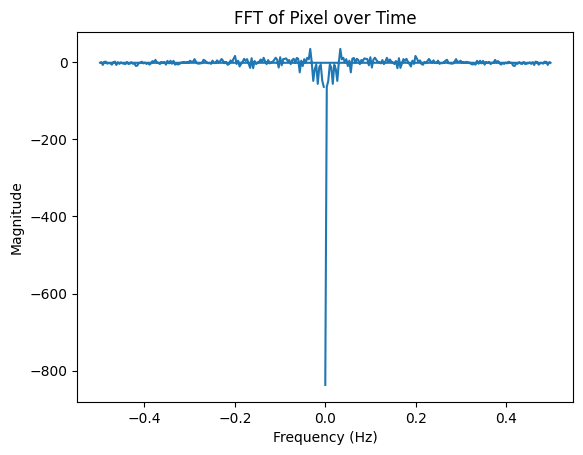

In [18]:
time_step = 1  # assuming the time step between samples is 1
frequencies = np.fft.fftfreq(len(pixel_series), time_step)

# Plot the magnitude of the FFT result
plt.plot(frequencies, fft_result)
plt.title('FFT of Pixel over Time')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [19]:
# Check Frequencies of Layer 1 at (0, 0)
pixel_series = np.array([filtered[:,1][i][0,0] for i in range(len(video))])
fft_result = np.fft.fft(pixel_series[:,0])

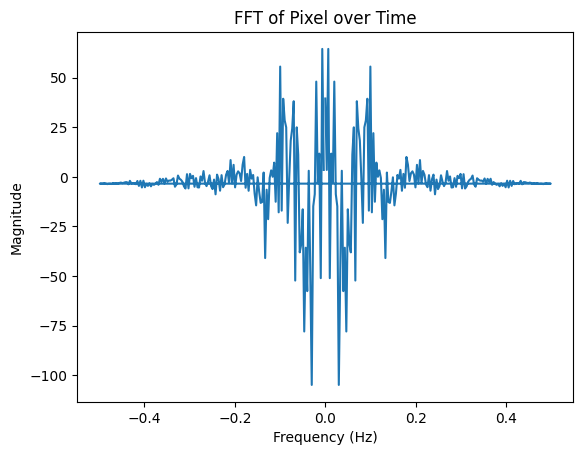

In [20]:
frequencies = np.fft.fftfreq(len(pixel_series), 1)

# Plot the magnitude of the FFT result
plt.plot(frequencies, fft_result)
plt.title('FFT of Pixel over Time')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [24]:
amplify("data/baby", 30, [0.3, 1.0], 300, 2, "results/baby_mag",reduce=True)

Reconstructing...: 100%|██████████| 301/301 [00:04<00:00, 74.81it/s]
